Summary Statistics:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      201.957515     116.376337     113.720571     206.643095   
std       298.495150     218.652659     158.946032     300.896893   
min       -19.500000      -7.800000     -17.900000       0.000000   
25%        -2.800000      -0.300000      -3.800000       0.000000   
50%         0.300000      -0.100000      -0.100000       3.600000   
75%       362.400000     107.000000     224.700000     359.500000   
max      1499.000000     946.000000     892.000000    1507.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      198.114691      26.319394      79.448857       1.146113   
std       288.889073       4.398605      20.520775       1.239248   
min         0.000000      12.300000       9.900000       0.000000   
25%         0

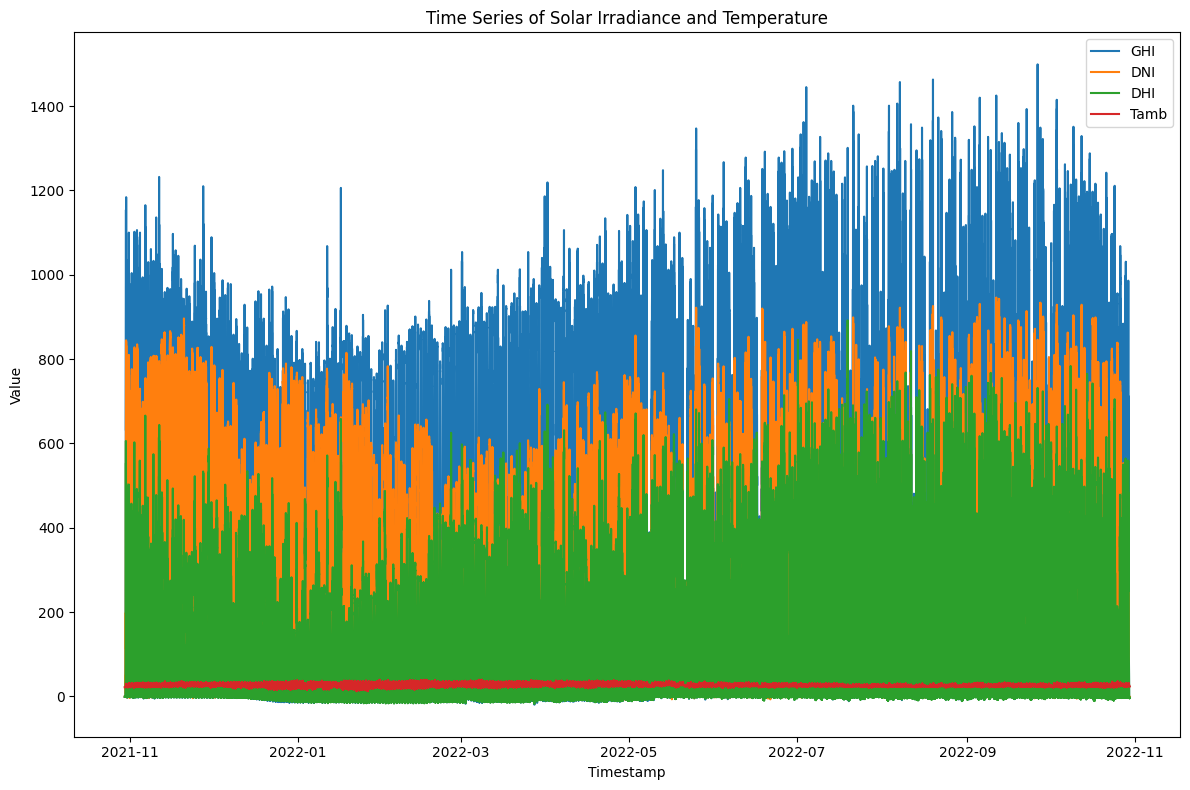

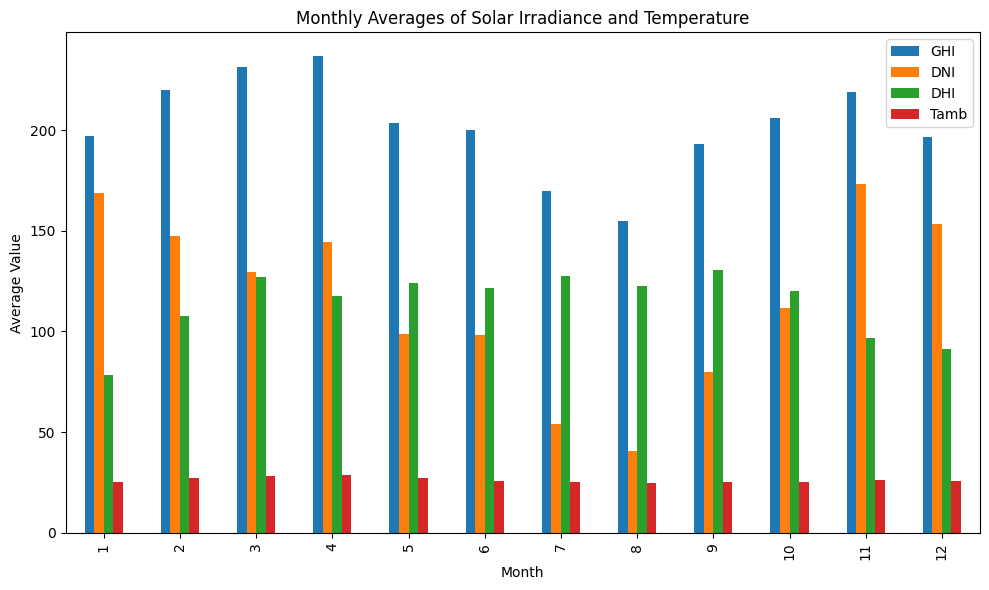

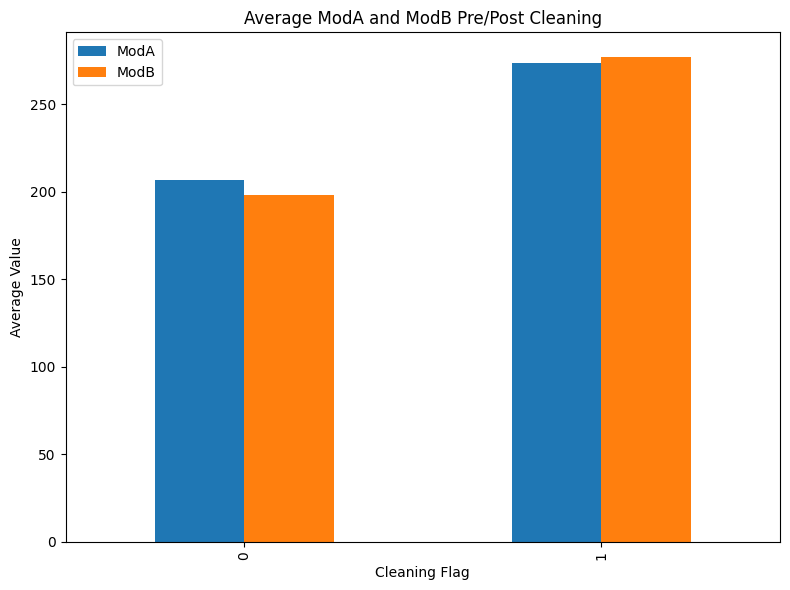

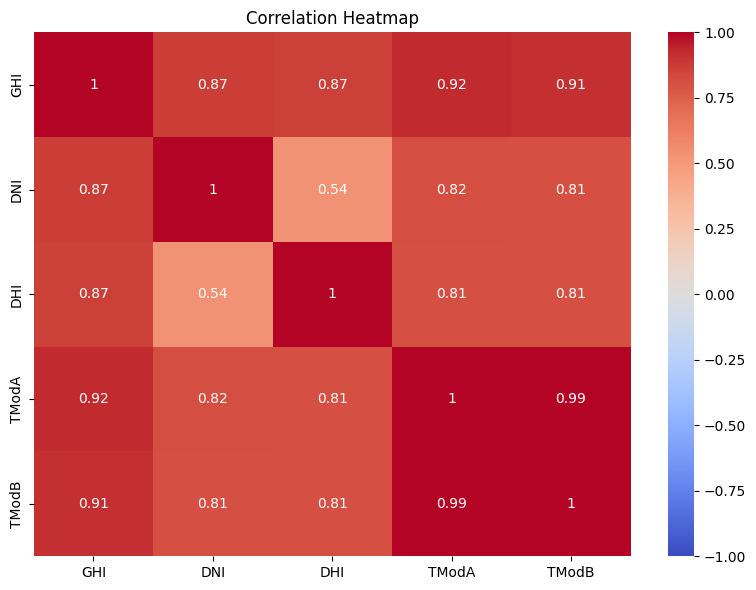

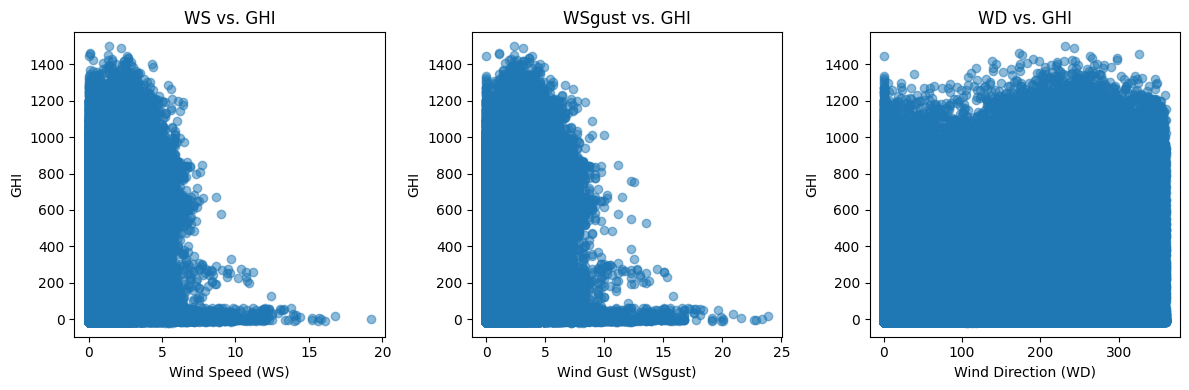

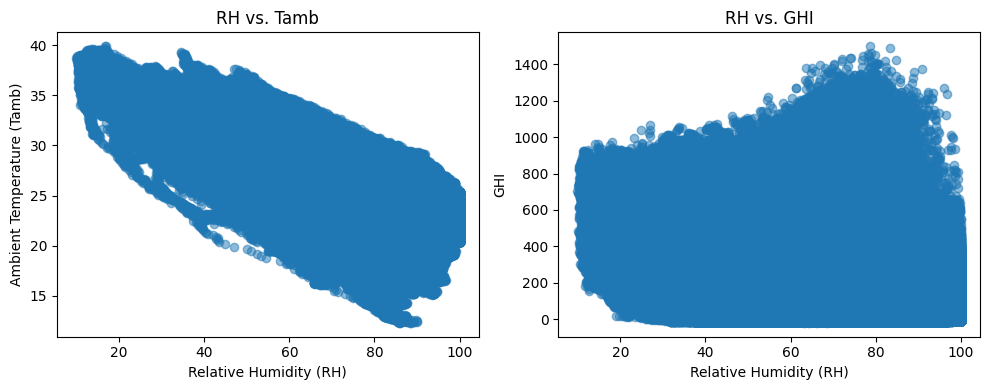

C:\Users\yorda\AppData\Local\Temp\ipykernel_27652\3655017250.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


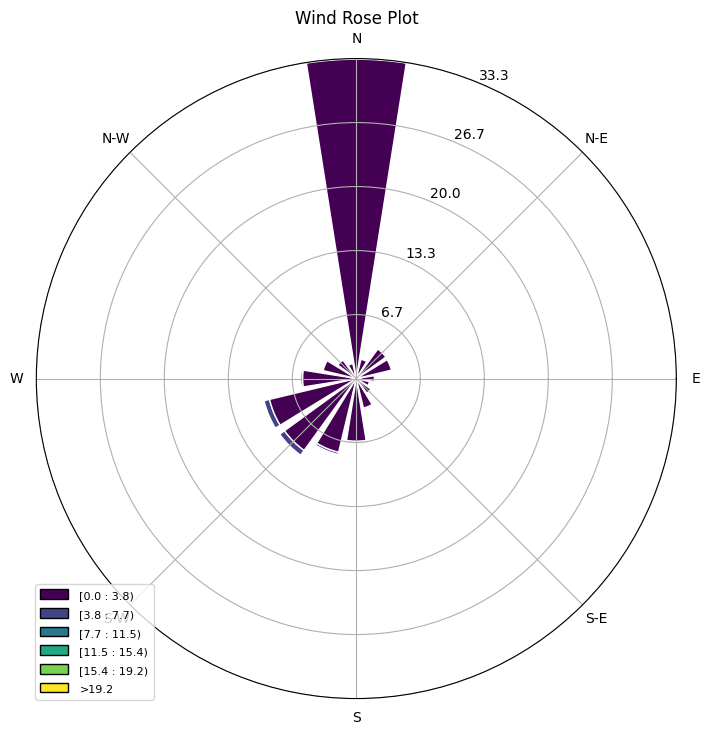

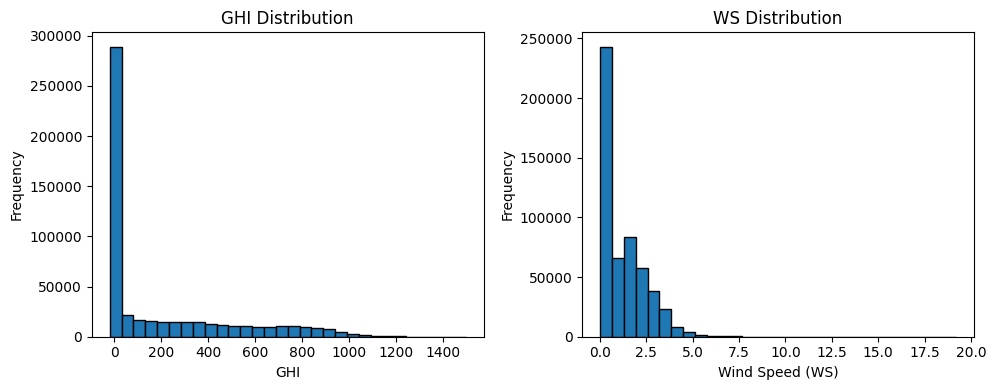


Temperature Analysis Insights:
RH vs. Tamb/GHI scatter plots indicate potential inverse relationships, suggesting higher humidity may correlate with lower temperatures or solar irradiance.


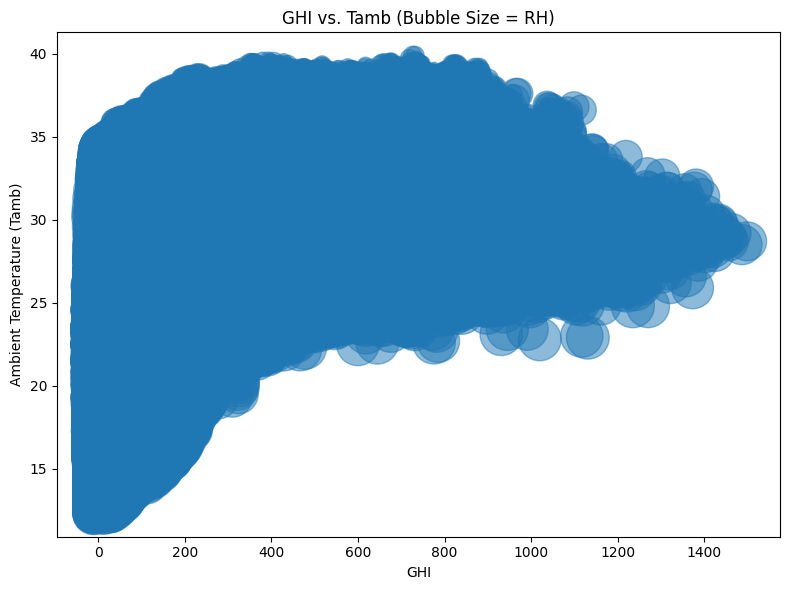


EDA Insights:
- High missing values (>5%) indicate potential sensor issues or data logging gaps.
- Outliers in GHI/DNI/DHI suggest possible sensor calibration errors.
- Monthly trends show seasonal variations in solar irradiance.
- Cleaning significantly impacts ModA/ModB, indicating maintenance effectiveness.
- Strong correlations between GHI/DNI/DHI suggest consistent solar patterns.
- Wind rose shows dominant wind directions, useful for panel orientation.
- RH may suppress GHI/Tamb, critical for performance modeling.

References:
- Pandas Documentation: https://pandas.pydata.org/docs/
- Seaborn Visualization: https://seaborn.pydata.org/
- Windrose Plot: https://windrose.readthedocs.io/
- Z-score Outlier Detection: https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from windrose import WindroseAxes
import uuid
import os

# Set random seed for reproducibility
np.random.seed(42)

# Load data 
df = pd.read_csv('data/sierraleone-bumbuna.csv')

# Create output directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# 1. Summary Statistics & Missing-Value Report
print("Summary Statistics:")
print(df.describe())
print("\nMissing Values:")
missing = df.isna().sum()
missing_pct = (missing / len(df) * 100)
print(missing)
print("\nColumns with >5% missing values:")
print(missing_pct[missing_pct > 5])

# 2. Outlier Detection & Basic Cleaning
# Compute Z-scores for key columns
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = df[key_columns].apply(stats.zscore)
outliers = (z_scores.abs() > 3).any(axis=1)
print(f"\nNumber of rows with outliers (|Z|>3): {outliers.sum()}")

# Impute missing values with median for key columns
for col in key_columns:
    if df[col].isna().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Drop rows with missing values in other columns if critical
df.dropna(subset=['Timestamp'], inplace=True)  # Timestamp is critical

# Export cleaned DataFrame
clean_file = 'data/sierraleone-bumbuna_clean.csv'
df.to_csv(clean_file, index=False)
print(f"\nCleaned data exported to {clean_file}")

# 3. Time Series Analysis
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Month'] = df['Timestamp'].dt.month
df['Hour'] = df['Timestamp'].dt.hour

# Plot GHI, DNI, DHI, Tamb vs. Timestamp
plt.figure(figsize=(12, 8))
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    plt.plot(df['Timestamp'], df[col], label=col)
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Time Series of Solar Irradiance and Temperature')
plt.legend()
plt.tight_layout()
plt.show()

# Monthly averages
monthly_avg = df.groupby('Month')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()
monthly_avg.plot(kind='bar', figsize=(10, 6))
plt.title('Monthly Averages of Solar Irradiance and Temperature')
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.tight_layout()
plt.show()

# 4. Cleaning Impact
cleaning_impact = df.groupby('Cleaning')[['ModA', 'ModB']].mean()
cleaning_impact.plot(kind='bar', figsize=(8, 6))
plt.title('Average ModA and ModB Pre/Post Cleaning')
plt.xlabel('Cleaning Flag')
plt.ylabel('Average Value')
plt.tight_layout()
plt.show()

# 5. Correlation & Relationship Analysis
# Correlation heatmap
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
corr_matrix = df[corr_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Scatter plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(df['WS'], df['GHI'], alpha=0.5)
plt.xlabel('Wind Speed (WS)')
plt.ylabel('GHI')
plt.title('WS vs. GHI')

plt.subplot(1, 3, 2)
plt.scatter(df['WSgust'], df['GHI'], alpha=0.5)
plt.xlabel('Wind Gust (WSgust)')
plt.ylabel('GHI')
plt.title('WSgust vs. GHI')

plt.subplot(1, 3, 3)
plt.scatter(df['WD'], df['GHI'], alpha=0.5)
plt.xlabel('Wind Direction (WD)')
plt.ylabel('GHI')
plt.title('WD vs. GHI')
plt.tight_layout()
plt.show()

# RH vs. Tamb and GHI
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(df['RH'], df['Tamb'], alpha=0.5)
plt.xlabel('Relative Humidity (RH)')
plt.ylabel('Ambient Temperature (Tamb)')
plt.title('RH vs. Tamb')

plt.subplot(1, 2, 2)
plt.scatter(df['RH'], df['GHI'], alpha=0.5)
plt.xlabel('Relative Humidity (RH)')
plt.ylabel('GHI')
plt.title('RH vs. GHI')
plt.tight_layout()
plt.show()

# 6. Wind & Distribution Analysis
# Wind rose plot
fig = plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(df['WD'], df['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Wind Rose Plot')
plt.tight_layout()
plt.show()

# Histograms
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df['GHI'], bins=30, edgecolor='black')
plt.xlabel('GHI')
plt.ylabel('Frequency')
plt.title('GHI Distribution')

plt.subplot(1, 2, 2)
plt.hist(df['WS'], bins=30, edgecolor='black')
plt.xlabel('Wind Speed (WS)')
plt.ylabel('Frequency')
plt.title('WS Distribution')
plt.tight_layout()
plt.show()

# 7. Temperature Analysis
# Already included in scatter plots (RH vs. Tamb, RH vs. GHI)
print("\nTemperature Analysis Insights:")
print("RH vs. Tamb/GHI scatter plots indicate potential inverse relationships, suggesting higher humidity may correlate with lower temperatures or solar irradiance.")

# 8. Bubble Chart
plt.figure(figsize=(8, 6))
plt.scatter(df['GHI'], df['Tamb'], s=df['RH']*10, alpha=0.5)
plt.xlabel('GHI')
plt.ylabel('Ambient Temperature (Tamb)')
plt.title('GHI vs. Tamb (Bubble Size = RH)')
plt.tight_layout()
plt.show()

